<a href="https://colab.research.google.com/github/QuocHiep123/pattern-recognition/blob/main/Nh%E1%BA%ADn_d%E1%BA%A1ng_m%E1%BA%ABu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# kết nối google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cài đặt các thư viện cần thiết
!pip install underthesea transformers torch accelerate scikit-learn seaborn matplotlib -q

import pandas as pd
import numpy as np
import re
import unicodedata
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Thư viện xử lý ngôn ngữ & ML cơ bản
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Thư viện Deep Learning (Keras/TensorFlow)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D, SimpleRNN, GRU
from tensorflow.keras.callbacks import EarlyStopping

# Thư viện Transformer (PhoBERT)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from torch import nn

# Thiết lập device cho PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.4 MB/s eta 0:00:00
Using device: cuda


In [3]:
# --- 1. TỪ ĐIỂN CHUẨN HÓA ---
NORMALIZATION_DICT = {
    "ko": "không", "k": "không", "kh": "không", "khong": "không", "kg": "không", "khum": "không",
    "dc": "được", "đc": "được", "dk": "được",
    "r": "rồi", "roi": "rồi",
    "t": "tôi", "mk": "mình", "mik": "mình",
    "sp": "sản phẩm", "shop": "cửa hàng",
    "gud": "tốt", "good": "tốt", "oke": "tốt", "ok": "tốt", "oki": "tốt",
    "yeu": "yêu", "iu": "yêu",
    "thik": "thích", "thic": "thích",
    "ship": "giao hàng",
    "nt": "nhắn tin", "ib": "nhắn tin",
    "tl": "trả lời", "rep": "trả lời",
    "feed": "đánh giá", "feedback": "đánh giá",
    "đỉnk": "đỉnh", "dink": "đỉnh",
    "lun": "luôn", "luN": "luôn", "lunn": "luôn",
    "xèg": "xài", "xeg": "xài", "nhu": "như",
    "hang": "hàng", "giong": "giống", "hinh": "hình", "chat": "chất",
    "luong": "lượng", "dep": "đẹp", "xau": "xấu", "qua": "quá",
    "ngon": "ngon", "thich": "thích", "mua": "mua", "giao": "giao",
    "nhanh": "nhanh", "la": "là", "rat": "rất"
}

EMOJI_DICT = {
    "❤️": " yêu_thích ", "🥰": " yêu_thích ", "😍": " yêu_thích ", "😘": " yêu_thích ",
    "🤩": " thích ", "👍": " tốt ", "👌": " tốt ",
    "😊": " vui ", "😁": " vui ", "😂": " cười ", "🤣": " cười ",
    "😡": " tức_giận ", "🤬": " chửi_bới ", "😤": " bực_mình ",
    "😭": " khóc ", "😢": " buồn ", "☹️": " buồn ", "😞": " thất_vọng ",
    "⭐": " sao ", "🌟": " sao "
}

!wget https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt -O stopwords.txt
def load_safe_stopwords():
    with open('stopwords.txt', 'r', encoding='utf-8') as f:
        stopwords = set([line.strip() for line in f])
    whitelist = {"không", "chẳng", "chả", "chưa", "đừng", "chớ", "ko", "k", "kh",
                 "rất", "quá", "lắm", "vô cùng", "cực", "hơi", "tuyệt", "tệ", "xấu", "đẹp", "ngon", "dở"}
    return stopwords - whitelist

STOPWORDS_VN = load_safe_stopwords()

# --- 2. CÁC HÀM XỬ LÝ CON ---
def normalize_unicode(text):
    return unicodedata.normalize('NFC', text)

def convert_emoji(text):
    for icon, word in EMOJI_DICT.items():
        text = text.replace(icon, word)
    return text

def normalize_teencode(text):
    words = text.split()
    return " ".join([NORMALIZATION_DICT.get(word, word) for word in words])

def remove_number(text):
    return re.sub(r'\b\d+\b', '', text) # Chỉ xóa số đứng một mình

def normalize_currency(text):
    text = re.sub(r'(\d+)\s*k\b', r'\1 nghìn', text, flags=re.IGNORECASE)
    text = re.sub(r'(\d+)\s*tr\b', r'\1 triệu', text, flags=re.IGNORECASE)
    return text

def remove_similarletter(text):
    return re.sub(r'([a-zđâăôơưê])\1+', r'\1', text)

def remove_stopword(text):
    words = text.split()
    return " ".join([w for w in words if w not in STOPWORDS_VN])

def pipeline_processsing(text):
    if not isinstance(text, str): return ""
    text = normalize_unicode(text)
    text = text.lower()
    text = convert_emoji(text)
    text = normalize_teencode(text)
    text = normalize_currency(text)
    text = remove_number(text)

    # Giữ lại tiếng Việt và dấu câu quan trọng
    pattern = r'[a-zaăâáắấàằầảẳẩãẵẫạặậđeêéếèềẻểẽễẹệiíìỉĩịoôơóốớòồờỏổởõỗỡọộợuưúứùừủửũữụựyýỳỷỹỵ!?,_ ]'
    char_list = [char if re.match(pattern, char) else ' ' for char in text]
    text = ''.join(char_list)

    text = remove_similarletter(text)
    text = " ".join(text.split()) # Xóa khoảng trắng thừa
    text = word_tokenize(text, format="text") # Tách từ
    text = remove_stopword(text)
    return text

print("Test Pipeline:", pipeline_processsing("Sp này giá 100k mà xài oke lắm nha mn ❤️❤️❤️!!!"))

--2026-01-09 07:12:48--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘stopwords.txt’

stopwords.txt       100%[===================>]  20.00K  --.-KB/s    in 0s      

2026-01-09 07:12:49 (133 MB/s) - ‘stopwords.txt’ saved [20475/20475]

Test Pipeline: sản_phẩm giá nghìn xài lắm nha mn yêu_thích yêu_thích yêu_thích ! ! !


In [4]:
# Đọc dữ liệu
try:
    df = pd.read_csv('/content/drive/MyDrive/dataset_NDM/data.csv')
    df = df.rename(columns={'content': 'text', 'label': 'label'})[['text', 'label']].dropna()
    print(f"Tổng số mẫu: {len(df)}")
except:
    print("⚠️ Lỗi: Không tìm thấy file data.csv")

# Chia tập Train/Test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Làm sạch dữ liệu
print(">>> Đang làm sạch dữ liệu (Pre-processing)...")
X_train_clean = X_train_raw.apply(pipeline_processsing)
X_test_clean = X_test_raw.apply(pipeline_processsing)
print("Xong!")

Tổng số mẫu: 31436
>>> Đang làm sạch dữ liệu (Pre-processing)...
Xong!


In [5]:
def build_sentiment_lexicon(X_data, y_data, top_n=2000):
    tfidf = TfidfVectorizer(ngram_range=(1,2))
    X_tfidf = tfidf.fit_transform(X_data)
    vocab = np.array(tfidf.get_feature_names_out())
    lexicon = set()
    y_arr = np.array(y_data)
    for label in np.unique(y_arr):
        mask = (y_arr == label)
        mean_score = np.asarray(X_tfidf[mask].mean(axis=0)).ravel()
        top_indices = mean_score.argsort()[-top_n:][::-1]
        lexicon.update(vocab[top_indices])
    return list(lexicon)

my_lexicon = build_sentiment_lexicon(X_train_clean, y_train)

ml_models = [
    ('Naïve Bayes (Lexicon)', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), vocabulary=my_lexicon)),
        ('nb', MultinomialNB())
    ])),
    ('Naïve Bayes (Full)', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=15000)),
        ('nb', MultinomialNB())
    ])),
    ('Logistic Regression', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=15000)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ])),
    ('Linear SVM', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=15000)),
        ('clf', LinearSVC(class_weight='balanced', dual='auto'))
    ])),
    ('Random Forest', Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=15000)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1))
    ]))
]

# 3. Huấn luyện
results = []
print("\n>>> KẾT QUẢ MACHINE LEARNING:")
for name, model in ml_models:
    model.fit(X_train_clean, y_train)
    y_pred = model.predict(X_test_clean)
    report = classification_report(y_test, y_pred, output_dict=True)

    neu_score = report['NEU']['f1-score'] if 'NEU' in report else 0
    print(f"- {name}: Acc={report['accuracy']:.2%}, Macro F1={report['macro avg']['f1-score']:.2%}")
    results.append({
        'Model': name, 'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'], 'NEU F1': neu_score
    })


>>> KẾT QUẢ MACHINE LEARNING:
- Naïve Bayes (Lexicon): Acc=77.00%, Macro F1=60.50%
- Naïve Bayes (Full): Acc=76.83%, Macro F1=55.93%
- Logistic Regression: Acc=73.19%, Macro F1=64.57%
- Linear SVM: Acc=75.05%, Macro F1=62.70%
- Random Forest: Acc=75.10%, Macro F1=62.01%


In [6]:
VOCAB_SIZE = 15000
MAX_LEN = 100
EMBEDDING_DIM = 100

# Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_clean)

# Padding
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_clean), maxlen=MAX_LEN, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test_clean), maxlen=MAX_LEN, padding='post')

# Encode Labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Lấy index của lớp NEU để theo dõi
neu_idx = str(label_encoder.transform(['NEU'])[0]) if 'NEU' in label_encoder.classes_ else '1'

In [7]:
def build_dl_model(model_type):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))

    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(64))
    elif model_type == 'GRU':
        model.add(GRU(64))
    elif model_type == 'LSTM':
        model.add(LSTM(64))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(64)))

    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

dl_model_names = ['SimpleRNN', 'GRU', 'LSTM', 'Bi-LSTM']

print("\n>>> KẾT QUẢ DEEP LEARNING:")
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for m_name in dl_model_names:
    print(f"⚙️ Training {m_name}...")
    model = build_dl_model(m_name)
    model.fit(X_train_seq, y_train_cat, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stop], verbose=0)

    y_pred_probs = model.predict(X_test_seq)
    y_pred_idx = np.argmax(y_pred_probs, axis=1)
    report = classification_report(y_test_enc, y_pred_idx, output_dict=True)

    neu_score = report[neu_idx]['f1-score'] if neu_idx in report else 0
    print(f" -> Acc={report['accuracy']:.2%}, Macro F1={report['macro avg']['f1-score']:.2%}")

    results.append({
        'Model': m_name, 'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'], 'NEU F1': neu_score
    })


>>> KẾT QUẢ DEEP LEARNING:
⚙️ Training SimpleRNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
 -> Acc=75.19%, Macro F1=51.64%
⚙️ Training GRU...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 -> Acc=63.87%, Macro F1=25.98%
⚙️ Training LSTM...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
 -> Acc=63.87%, Macro F1=25.98%
⚙️ Training Bi-LSTM...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/keras/src

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
 -> Acc=78.20%, Macro F1=61.41%


In [8]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights tự động tính toán: {class_weights}")

MODEL_NAME = "vinai/phobert-base"
tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
model_bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = SentimentDataset(X_train_clean.to_list(), y_train_enc, tokenizer_bert, MAX_LEN)
test_dataset = SentimentDataset(X_test_clean.to_list(), y_test_enc, tokenizer_bert, MAX_LEN)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Áp dụng trọng số đã tính ở trên
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'macro_f1': macro_f1}

training_args = TrainingArguments(
    output_dir='./results', num_train_epochs=3, # Chạy 3 vòng là đủ
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    warmup_steps=500, weight_decay=0.01, logging_dir='./logs',
    eval_strategy="epoch", save_strategy="no", learning_rate=2e-5, report_to="none"
)

# 4. Huấn luyện
print("\n>>> FINE-TUNING PHOBERT (CÓ TRỌNG SỐ)...")
trainer = CustomTrainer(
    model=model_bert, args=training_args,
    train_dataset=train_dataset, eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

# 5. Đánh giá
print("\n>>> ĐÁNH GIÁ KẾT QUẢ PHOBERT...")
preds_output = trainer.predict(test_dataset)
y_pred_bert = preds_output.predictions.argmax(-1)
report_bert = classification_report(y_test_enc, y_pred_bert, output_dict=True)

results.append({
    'Model': 'PhoBERT (Weighted)', 'Accuracy': report_bert['accuracy'],
    'Macro F1': report_bert['macro avg']['f1-score'],
    'NEU F1': report_bert[str(label_encoder.transform(['NEU'])[0])]['f1-score']
})
print(f"PhoBERT Accuracy: {report_bert['accuracy']:.2%}")

Class Weights tự động tính toán: tensor([1.5724, 2.2324, 0.5219], device='cuda:0')


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



>>> FINE-TUNING PHOBERT (CÓ TRỌNG SỐ)...


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.727000,0.710492,0.730598,0.650211
2,0.658200,0.720888,0.748728,0.660058
3,0.600700,0.730566,0.743162,0.659886



>>> ĐÁNH GIÁ KẾT QUẢ PHOBERT...


PhoBERT Accuracy: 74.32%



🏆 BẢNG XẾP HẠNG CUỐI CÙNG:
                   Model  Accuracy  Macro F1  NEU F1
9     PhoBERT (Weighted)    74.32%    65.99%  40.03%
2    Logistic Regression    73.19%    64.57%  38.98%
3             Linear SVM    75.05%    62.70%  32.19%
4          Random Forest    75.10%    62.01%  30.14%
8                Bi-LSTM    78.20%    61.41%  23.67%
0  Naïve Bayes (Lexicon)    77.00%    60.50%  23.80%
1     Naïve Bayes (Full)    76.83%    55.93%  11.15%
5              SimpleRNN    75.19%    51.64%   1.46%
7                   LSTM    63.87%    25.98%   0.00%
6                    GRU    63.87%    25.98%   0.00%


/tmp/ipython-input-510042691.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_res, x='Macro F1', y='Model', palette='viridis')


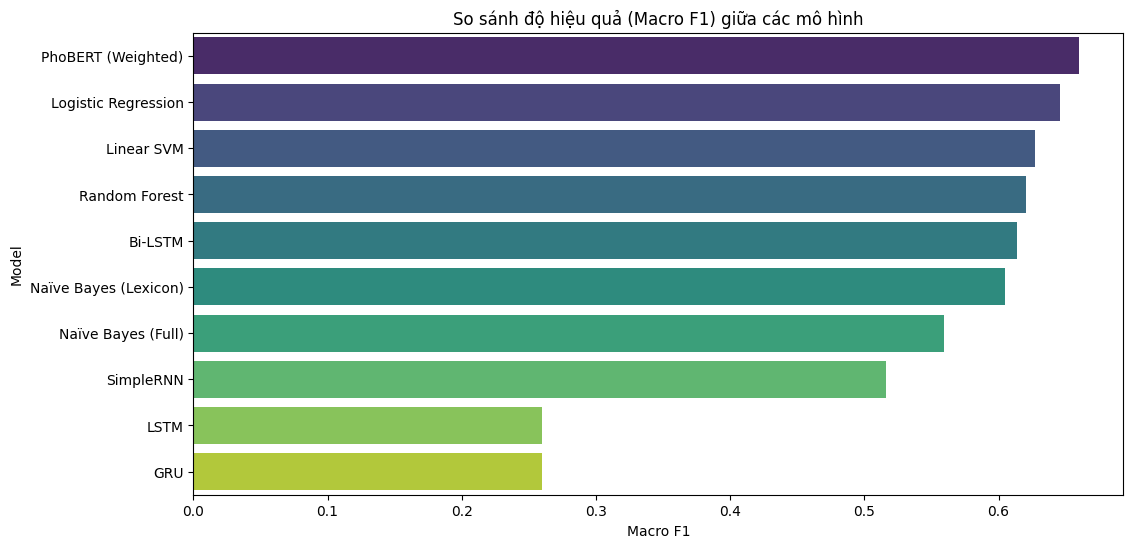

In [9]:
df_res = pd.DataFrame(results).sort_values(by='Macro F1', ascending=False)
pd.options.display.float_format = '{:.2%}'.format
print("\n🏆 BẢNG XẾP HẠNG CUỐI CÙNG:")
print(df_res)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_res, x='Macro F1', y='Model', palette='viridis')
plt.title('So sánh độ hiệu quả (Macro F1) giữa các mô hình')
plt.savefig('model_comparison.png', bbox_inches='tight')
plt.show()

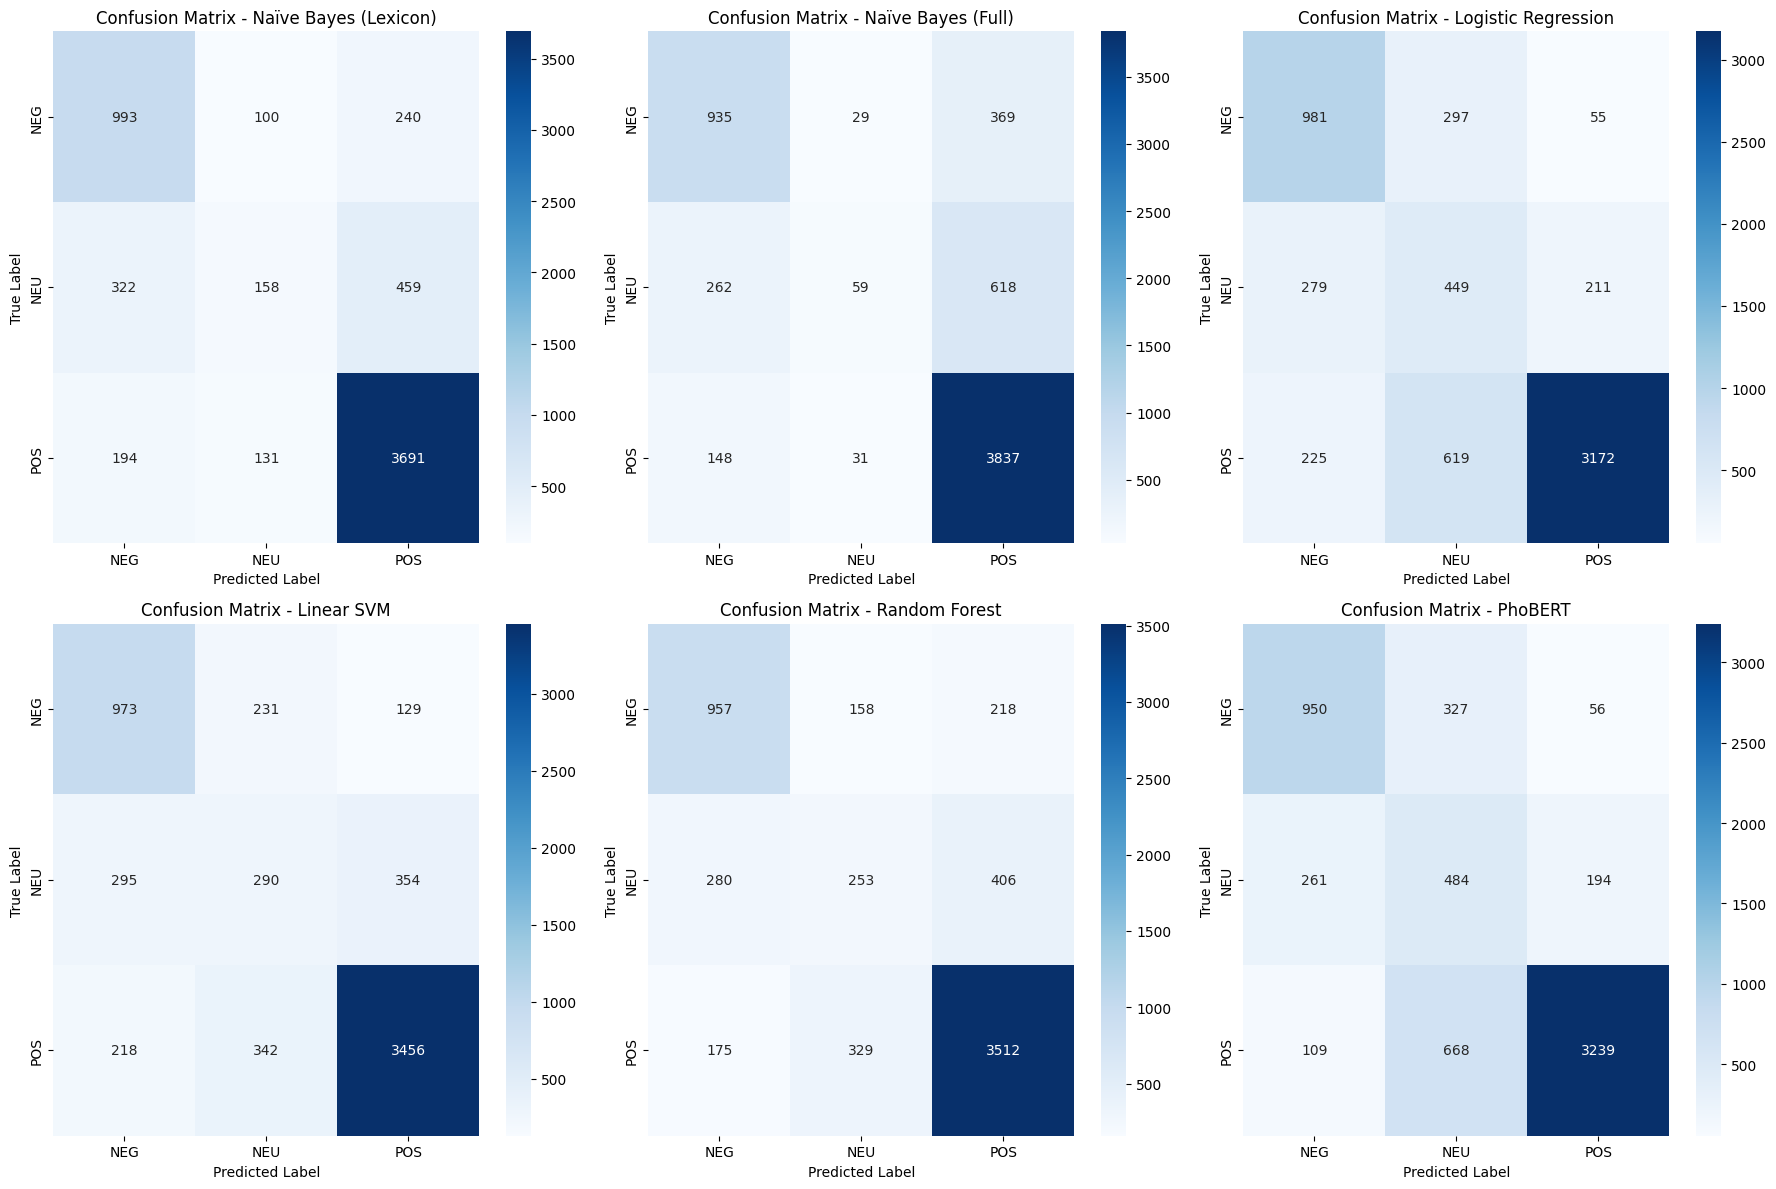

In [10]:
from sklearn.metrics import confusion_matrix
import math

# Thu thập dữ liệu dự đoán để vẽ Confusion Matrix
models_to_plot = []

# 1. Các model Machine Learning
# Lưu ý: ml_models đã được fit ở cell trước
for name, model in ml_models:
    y_pred = model.predict(X_test_clean)
    models_to_plot.append((name, y_test, y_pred))

# 2. PhoBERT (nếu đã chạy)
if 'y_pred_bert' in globals() and 'y_test_enc' in globals() and 'label_encoder' in globals():
    # Chuyển đổi từ số về nhãn gốc để đồng bộ với ML models
    y_true_bert = label_encoder.inverse_transform(y_test_enc)
    y_pred_bert_lbl = label_encoder.inverse_transform(y_pred_bert)
    models_to_plot.append(('PhoBERT', y_true_bert, y_pred_bert_lbl))

# Vẽ biểu đồ
num_models = len(models_to_plot)
cols = 3
rows = math.ceil(num_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axes = axes.flatten()

# Lấy danh sách các nhãn (class names)
unique_labels = sorted(list(set(y_test)))

for i, (name, y_true, y_pred) in enumerate(models_to_plot):
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels, ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - {name}")
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

# Ẩn các subplot thừa nếu có
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Tài liệu tham khảo :

Thuật toán naive Bayes: https://www.ijml.org/papers/409-LC010.pdf

TF-IDF: https://aclanthology.org/P10-1141.pdf

Logistic Regression: https://sci-hub.mk/10.1111/j.2517-6161.1958.tb00292.x

Support Vector Machine (SVM): https://homepages.math.uic.edu/~lreyzin/papers/cortes95.pdf

Random Forest: https://jmlr.org/papers/volume13/biau12a/biau12a.pdf

LSTM: https://www.researchgate.net/publication/13853244_Long_Short-Term_Memory

GRU (Gated Recurrent Unit):https://arxiv.org/pdf/1406.1078

Bi-LSTM (Bidirectional LSTM): https://www.sciencedirect.com/topics/computer-science/bidirectional-long-short-term-memory-network

PhoBERT: Pre-trained language models for Vietnamese
https://aclanthology.org/2020.findings-emnlp.92.pdf


VNCoreNLP: https://aclanthology.org/N18-5012.pdf

